# Transfer Learning MNIST

* Train a simple convnet on the MNIST dataset the first 5 digits [0-4].
* Freeze convolutional layers and fine-tune dense layers for the classification of digits [5-9].

## MNIST Dataset
The MNIST database contains 60,000 training images and 10,000 testing images taken from American Census Bureau employees and American high school students. The MNIST dataset is one of the most common datasets used for image classification and accessible from many different sources. In fact, even Tensorflow and Keras allow us to import and download the MNIST dataset directly from their API.

Let's import keras and load MNIST dataset

In [1]:
# Initialize the random number generator
import random
random.seed(0)

import numpy as np
import pandas as pd

import tensorflow
import keras

from keras.models import Sequential
from keras.layers import Conv2D,Add, Dense, MaxPool2D, Dropout, Flatten, Activation
from keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
from keras.backend import backend
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train and X_test contain greyscale RGB codes (from 0 to 255) while y_train and y_test contains labels from 0 to 9 which represents which number they actually are.

Let's visualize some numbers using matplotlib

Label: 0


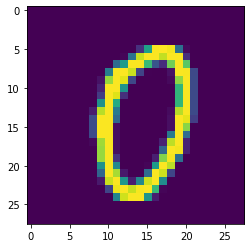

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
print("Label: {}".format(y_train[1000]))
plt.imshow(X_train[1000])

## Question 1

### Create two datasets
- First having digits from 0 to 4
- Second having digits from 5 to 9

Hint: use labels to separate data

In [4]:
# understanding the unique lables in test & train
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [5]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### Split the test and train for CNN / Transfer learning model

In [6]:
np.unique(y_train[y_train < 5])

array([0, 1, 2, 3, 4], dtype=uint8)

In [7]:
np.unique(y_train[y_train >= 5])

array([5, 6, 7, 8, 9], dtype=uint8)

In [0]:
# CNN data-set where the labels are between 0 & 4

cnn_trainX = X_train[y_train < 5]
cnn_trainY = y_train[y_train < 5]

cnn_testX = X_test[y_test < 5]
cnn_testY = y_test[y_test < 5]

In [0]:
# Transfer learning data-set where the labels are between 5 & 9

TL_trainX = X_train[y_train >= 5]
TL_trainY = y_train[y_train >= 5]

TL_testX = X_test[y_test >= 5]
TL_testY = y_test[y_test >= 5]


## Question 2

### Print shape of the data
- print shape of all variables of both the datasets you created

In [10]:
print('shape for CNN train data-set are{}{}'.format(cnn_trainX.shape,cnn_trainY.shape))
print('shape for CNN test data-set are{}{}'.format(cnn_testY.shape, cnn_testY.shape))

print('shape for Transfer learning train data-set are{}{}'.format(TL_trainX.shape,TL_trainY.shape))
print('shape for Transfer learning test data-set are{}{}'.format(TL_testY.shape, TL_testY.shape))

shape for CNN train data-set are(30596, 28, 28)(30596,)
shape for CNN test data-set are(5139,)(5139,)
shape for Transfer learning train data-set are(29404, 28, 28)(29404,)
shape for Transfer learning test data-set are(4861,)(4861,)


## Question 3

### Reshape data
- reshape first dataset
- To be able to use the dataset in Keras, we need 4-dims numpy arrays. 
- reshape features to pass it to a Conv2D layer
- channel = 1
- reshape features of first dataset only
- do not reshape labels

In [0]:
cnn_trainX = cnn_trainX.reshape(cnn_trainX.shape[0],28,28,1)
cnn_testX = cnn_testX.reshape(cnn_testX.shape[0],28,28,1)


In [12]:
cnn_trainX.shape

(30596, 28, 28, 1)

## Question 4

### Normalize data
- normalize first dataset
- we must normalize our data as it is always required in neural network models
- we can achieve this by dividing the RGB codes to 255 (which is the maximum RGB code minus the minimum RGB code)
- normalize X_train and X_test
- make sure that the values are float so that we can get decimal points after division

In [0]:
cnn_trainX = cnn_trainX.astype(np.float32) / 255
cnn_testX = cnn_testX.astype(np.float32) / 255


### Print shape of data and number of images
- for first dataset
- print shape of X_train
- print number of images in X_train
- print number of images in X_test

In [14]:
print('shape for CNN train data-set are{}{}'.format(cnn_trainX.shape,cnn_trainY.shape))
print('shape for CNN test data-set are{}{}'.format(cnn_testY.shape, cnn_testY.shape))

shape for CNN train data-set are(30596, 28, 28, 1)(30596,)
shape for CNN test data-set are(5139,)(5139,)


## Question 5

### One-hot encode the class vector
- encode labels of first dataset
- convert class vectors (integers) to binary class matrix
- convert y_train and y_test
- number of classes: 5
- we are doing this to use categorical_crossentropy as loss

Hint: you can use keras.utils.to_categorical

In [15]:
cnn_trainY = keras.utils.to_categorical(cnn_trainY,num_classes=5)
cnn_testY =  keras.utils.to_categorical(cnn_testY, num_classes=5)

print('label output after encoding',cnn_testY[0])

label output after encoding [0. 0. 1. 0. 0.]


## Question 6
We will build our model by using high level Keras.

### Initialize a sequential model
- define a sequential model
- add 2 convolutional layers
    - no of filters: 32
    - kernel size: 3x3
    - activation: "relu"
    - input shape: (28, 28, 1) for first layer
- add a max pooling layer of size 2x2
- add a dropout layer
    - dropout layers fight with the overfitting by disregarding some of the neurons while training
    - use dropout rate 0.2

In [16]:
# Create the model
cnn_model = Sequential()

# add a conv layer
cnn_model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu', name='conv1'))
cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', name='conv2'))

# add a pool layer
cnn_model.add( MaxPool2D(pool_size=(2,2), name='conv_pool1') )

# add a drop out layer
cnn_model.add(Dropout(0.2, name='conv_dr'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Question 7

### Add classification layers
- do this after doing question 6
- flatten the data
    - add Flatten later
    - flatten layers flatten 2D arrays to 1D array before building the fully connected layers
- add 2 dense layers
    - number of neurons in first layer: 128
    - number of neurons in last layer: number of classes
    - activation function in first layer: relu
    - activation function in last layer: softmax
    - we may experiment with any number of neurons for the first Dense layer; however, the final Dense layer must have neurons equal to the number of output classes
- you can add a dropout layer in between, if necessary

In [0]:
# flatten the Conv output for fully connected layer
cnn_model.add(Flatten())

# add a dense layer
cnn_model.add(Dense(128))
cnn_model.add(Activation('relu'))

cnn_model.add(Dense(5))
cnn_model.add(Activation('softmax'))


In [18]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        9248      
_________________________________________________________________
conv_pool1 (MaxPooling2D)    (None, 12, 12, 32)        0         
_________________________________________________________________
conv_dr (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

## Question 8

### Compile and fit the model
- compile your model
    - loss: "categorical_crossentropy"
    - metrics: "accuracy"
    - optimizer: "sgd"
- fit your model
    - give train data - features and labels
    - batch size: 128
    - epochs: 10
    - give validation data - features and labels

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)


cnn_model.compile(optimizer='sgd',loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

m_his = cnn_model.fit(cnn_trainX,cnn_trainY, validation_split=0.20, epochs=30, callbacks=[early_stopping])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 24476 samples, validate on 6120 samples
Epoch 1/30





24476/24476 [==============================] - 6s 261us/step - loss: 0.2505 - acc: 0.9296 - val_loss: 0.0995 - val_acc: 0.9694
Epoch 2/30
24476/24476 [==============================] - 3s 141us/step - loss: 0.1098 - acc: 0.9659 - val_loss: 0.0877 - val_acc: 0.9706
Epoch 3/30
24476/24476 [==============================] - 3s 130us/step - loss: 0.0881 - acc: 0.9725 - val_loss: 0.0611 - val_acc: 0.9827
Epoch 4/30
24476/24476 [==============================] - 3s 133us/step - loss: 0.0715 - acc: 0.9781 - val_loss: 0.0523 - val_acc: 0.9838
Epoch 5/30
24476/24476 [==============================] - 3s 136us/step - loss: 0.0617 - acc: 0.9802 - val_loss: 0.0462 - val_acc: 0.9855
Epoch 6/30
24476/24476 [==============================] - 3s 136us/step - loss: 0.0534 - acc: 0.9830 - val_loss: 0.0429 - val_acc: 0.9868
Epoch 7/30
24476/24

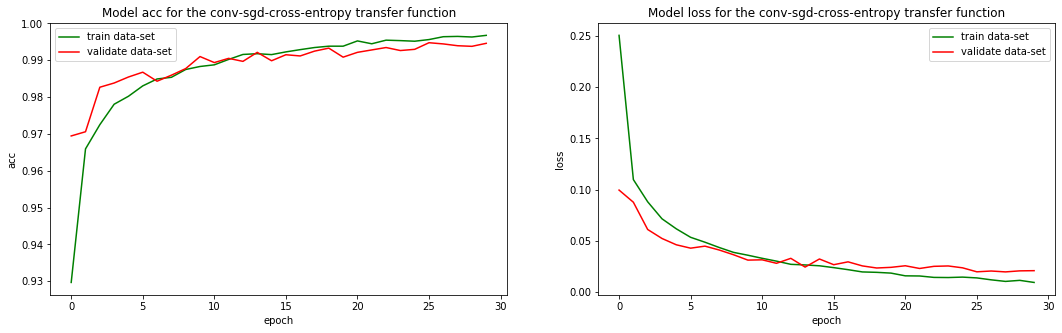

In [20]:
def plot_model_history(ax, history, train_metric, val_metric, actv_func ):
  ax.plot(history[train_metric], 'green',label='train data-set')
  ax.plot(history[val_metric], 'red',label='validate data-set')
  ax.set_title('Model {} for the {} transfer function'.format(train_metric,actv_func))
  ax.set_ylabel(train_metric)
  ax.set_xlabel('epoch')
  ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(18,5))
plot_model_history(ax[0], m_his.history, 'acc', 'val_acc', 'conv-sgd-cross-entropy')
plot_model_history(ax[1], m_his.history, 'loss', 'val_loss', 'conv-sgd-cross-entropy')

## Question 9

### Evaluate model
- evaluate your model and get accuracy
- use test features and labels

In [21]:
cnn_model.evaluate(cnn_testX,cnn_testY)

5139/5139 [==============================] - 0s 57us/step


[0.010754550862207848, 0.9968865538042421]

## Question 10

## Transfer learning
Now we will apply this model on second dataset (5-9 digits)

- fix the first convolution layers so that the weights in the convolution layers dont get updated in the process of training
- get the second dataset
- train the last 2 dense layers
- predict the accuracy and loss

### Make only dense layers trainable
- set trainalble = False for all layers other than Dense layers

In [22]:
# create the model for transfer learning
TL_model = Sequential()

# mark trainable parameters as false for conv layers being added from earlier build model 
for layer in cnn_model.layers:
    if ( (layer.name == 'conv1') | (layer.name == 'conv2') | (layer.name == 'conv_pool1') | (layer.name == 'conv_dr') ):
        layer.trainable = False

    TL_model.add(layer)

TL_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        9248      
_________________________________________________________________
conv_pool1 (MaxPooling2D)    (None, 12, 12, 32)        0         
_________________________________________________________________
conv_dr (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

### Modify data
- in your second data, class labels will start from 5 to 9 but for keras.utils.to_categorical the labels should start from 0
- so you need to subtract 5 from train and test labels

In [23]:
TL_trainY = TL_trainY - 5
TL_testY  = TL_testY - 5

np.unique(TL_trainY) 

array([0, 1, 2, 3, 4], dtype=uint8)

### Reshape data
- reshape second dataset
- To be able to use the dataset in Keras, we need 4-dims numpy arrays. 
- reshape features to pass it to a Conv2D layer
- channel = 1
- reshape features of first dataset only
- do not reshape labels

In [0]:

TL_trainX = TL_trainX.reshape(TL_trainX.shape[0],28,28,1)
TL_testX = TL_testX.reshape(TL_testX.shape[0],28,28,1)


### Normalize data
- normalize second data
- we must normalize our data as it is always required in neural network models
- we can achieve this by dividing the RGB codes to 255 (which is the maximum RGB code minus the minimum RGB code)
- normalize X_train and X_test
- make sure that the values are float so that we can get decimal points after division

In [0]:
TL_trainX = TL_trainX.astype(np.float32) / 255
TL_testX = TL_testX.astype(np.float32) / 255

### Print shape of data and number of images
- print shape of X_train
- print number of images in X_train
- print number of images in X_test

In [26]:
print('shape for transfer learning train data-set are{}{}'.format(TL_trainX.shape,TL_trainY.shape))
print('shape for transfer learning test data-set are{}{}'.format(TL_testY.shape, TL_testY.shape))

shape for transfer learning train data-set are(29404, 28, 28, 1)(29404,)
shape for transfer learning test data-set are(4861,)(4861,)


### One-hot encode the class vector
- convert class vectors (integers) to binary class matrix
- convert y_train and y_test
- number of classes: 5
- we are doing this to use categorical_crossentropy as loss

Hint: you can use keras.utils.to_categorical

In [27]:
TL_trainY = keras.utils.to_categorical(TL_trainY,num_classes=5)
TL_testY =  keras.utils.to_categorical(TL_testY, num_classes=5)

print('label output after encoding',TL_testY[0])

label output after encoding [0. 0. 1. 0. 0.]


### Fit the model
- give train data - features and labels
- batch size: 128
- epochs: 10
- give validation data - features and labels

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

TL_model.compile(optimizer='sgd',loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
TL_m_his = TL_model.fit(TL_trainX,TL_trainY, validation_split=0.20, epochs=10, batch_size=128,  callbacks=[early_stopping])

Train on 23523 samples, validate on 5881 samples
Epoch 1/10
23523/23523 [==============================] - 1s 48us/step - loss: 0.4326 - acc: 0.8845 - val_loss: 0.1711 - val_acc: 0.9466
Epoch 2/10
23523/23523 [==============================] - 1s 35us/step - loss: 0.1594 - acc: 0.9481 - val_loss: 0.1359 - val_acc: 0.9600
Epoch 3/10
23523/23523 [==============================] - 1s 34us/step - loss: 0.1273 - acc: 0.9605 - val_loss: 0.1099 - val_acc: 0.9680
Epoch 4/10
23523/23523 [==============================] - 1s 36us/step - loss: 0.1090 - acc: 0.9671 - val_loss: 0.1022 - val_acc: 0.9709
Epoch 5/10
23523/23523 [==============================] - 1s 37us/step - loss: 0.0993 - acc: 0.9680 - val_loss: 0.0951 - val_acc: 0.9721
Epoch 6/10
23523/23523 [==============================] - 1s 37us/step - loss: 0.0910 - acc: 0.9708 - val_loss: 0.0916 - val_acc: 0.9743
Epoch 7/10
23523/23523 [==============================] - 1s 39us/step - loss: 0.0847 - acc: 0.9733 - val_loss: 0.0879 - val_acc:

### Evaluate model
- evaluate your model and get accuracy
- use test features and labels

In [29]:
TL_model.evaluate(TL_testX,TL_testY)

4861/4861 [==============================] - 0s 60us/step


[0.06153172313534007, 0.9804566960426987]

-----------------------------------------------------------------------------

# Sentiment analysis 

The objective of the second problem is to perform Sentiment analysis from the tweets collected from the users targeted at various mobile devices.
Based on the tweet posted by a user (text), we will classify if the sentiment of the user targeted at a particular mobile device is positive or not.

## Question 1

### Read the data
- read tweets.csv
- use latin encoding if it gives encoding error while loading

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
! ls '/content/drive/My Drive/1.Dataset'

india-news-headlines.csv	    SVHN_single_grey1.h5
plant-seedlings-classification-CNN  tweets.csv
plant-seedlings-classification.zip


In [0]:
df = pd.read_csv('/content/drive/My Drive/1.Dataset/tweets.csv', encoding='latin')


In [33]:
df.shape

(9093, 3)

### Drop null values
- drop all the rows with null values

In [34]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [0]:
df.dropna(inplace=True)

In [36]:
df.shape

(3291, 3)

In [37]:
df.isnull().sum()


tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

Print the dataframe
- print initial 5 rows of the data
- use df.head()

In [38]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Question 2

### Preprocess data
- convert all text to lowercase - use .lower()
- select only numbers, alphabets, and #+_ from text - use re.sub()
- strip all the text - use .strip()
    - this is for removing extra spaces

In [0]:
import re
df = df.applymap(lambda s: s.lower())
df = df.applymap(lambda s: re.sub('[^0-9a-z #+_]',"",s))
df = df.applymap(lambda s: s.strip())

print dataframe

In [40]:
df.sample(5,random_state=3)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
4794,+1 rt mention petricone says google tv is just...,other google product or service,positive emotion
6051,rt mention i feel like my iphone always on alw...,iphone,negative emotion
7818,guess everyone wanted to design ipad apps for ...,ipad or iphone app,negative emotion
2503,its pie day at the google booth at #sxsw #mylunch,google,positive emotion
8831,geez #sxsw people are eating this up another l...,ipad,i cant tell


## Question 3

### Preprocess data
- in column "is_there_an_emotion_directed_at_a_brand_or_product"
    - select only those rows where value equal to "positive emotion" or "negative emotion"
- find the value counts of "positive emotion" and "negative emotion"

In [0]:
df = df[ (df['is_there_an_emotion_directed_at_a_brand_or_product']== 'positive emotion') | (df['is_there_an_emotion_directed_at_a_brand_or_product']== 'negative emotion') ]

In [42]:
df.shape

(3191, 3)

In [43]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

positive emotion    2672
negative emotion     519
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

## Question 4

### Encode labels
- in column "is_there_an_emotion_directed_at_a_brand_or_product"
    - change "positive emotion" to 1
    - change "negative emotion" to 0
- use map function to replace values

In [0]:
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({'positive emotion':1,'negative emotion':0})

In [45]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

1    2672
0     519
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

## Question 5

### Get feature and label
- get column "tweet_text" as feature
- get column "is_there_an_emotion_directed_at_a_brand_or_product" as label

In [0]:
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

### Create train and test data
- use train_test_split to get train and test set
- set a random_state
- test_size: 0.25

In [0]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=3)

In [48]:
print('shape for train data-set{}{}'.format(x_train.shape,y_train.shape))
print('shape for test data-set{}{}'.format(x_test.shape,y_test.shape))

shape for train data-set(2393,)(2393,)
shape for test data-set(798,)(798,)


## Question 6

### Vectorize data
- create document-term matrix
- use CountVectorizer()
    - ngram_range: (1, 2)
    - stop_words: 'english'
    - min_df: 2   
- do fit_transform on X_train
- do transform on X_test

In [0]:
# instantiate the vectorizer
vect = CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=2)

# learn training data vocabulary, then use it to create a document-term matrix
x_train_dtm = vect.fit_transform(x_train)


In [50]:
print('train DTM shape{}'.format(x_train_dtm.shape))

train DTM shape(2393, 5433)


In [51]:
vect.get_feature_names()[:10]

['10', '10 hot', '100', '101', '10x', '11', '11ntc', '11ntc sxsw', '12', '136']

In [0]:
# transform testing data into a document-term matrix
x_test_dtm = vect.transform(x_test)

In [53]:
print('test DTM shape{}'.format(x_test_dtm.shape))

test DTM shape(798, 5433)


## Question 7

### Select classifier logistic regression
- use logistic regression for predicting sentiment of the given tweet
- initialize classifier

In [0]:
# instantiate a logistic regression model
logreg = LogisticRegression()

### Fit the classifer
- fit logistic regression classifier

In [55]:
# train the model using X_train_dtm
logreg.fit(x_train_dtm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Question 8

### Select classifier naive bayes
- use naive bayes for predicting sentiment of the given tweet
- initialize classifier
- use MultinomialNB

In [0]:
#instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

### Fit the classifer
- fit naive bayes classifier

In [57]:
# train the model using X_train_dtm
nb.fit(x_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Question 9

### Make predictions on logistic regression
- use your trained logistic regression model to make predictions on X_test

In [0]:
# make class predictions for X_test_dtm
lr_y_pred = logreg.predict(x_test_dtm)

### Make predictions on naive bayes
- use your trained naive bayes model to make predictions on X_test
- use a different variable name to store predictions so that they are kept separately

In [0]:
# make class predictions for X_test_dtm
nb_y_pred = nb.predict(x_test_dtm)

## Question 10

### Calculate accuracy of logistic regression
- check accuracy of logistic regression classifer
- use sklearn.metrics.accuracy_score

In [60]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, lr_y_pred)

0.8784461152882206

### Calculate accuracy of naive bayes
- check accuracy of naive bayes classifer
- use sklearn.metrics.accuracy_score

In [61]:
#calculate accuracy of class predictions
metrics.accuracy_score(y_test, nb_y_pred)

0.87468671679198